In [2]:
%load_ext autoreload
%autoreload 2

import os
os.environ['KMP_WARNINGS'] = 'off'
import sys
import git

import uproot as ut
import awkward as ak
import numpy as np
import math
import vector
import sympy as sp

import re
from tqdm import tqdm
import timeit
import re

sys.path.append( git.Repo('.', search_parent_directories=True).working_tree_dir )
from utils import *

In [3]:
f_signal = ['/store/user/ekoenig/MultiHiggs/DiHiggs/RunII/FeynNetTraining_19July2023/NTuple_GluGluToHHTo4B_cHHH1_TuneCP5_PSWeights_13TeV-powheg-pythia8_CentralUL2018/ntuple.root']
f_qcd = ['/store/user/ekoenig/MultiHiggs/DiHiggs/RunII/FeynNetTraining_27June2023/ForFeynNet_UL18_SignalPlusBackground_27June2023/QCD*bEn*/train_ntuple.root','/store/user/ekoenig/MultiHiggs/DiHiggs/RunII/FeynNetTraining_27June2023/ForFeynNet_UL18_SignalPlusBackground_27June2023/QCD*BGen*/train_ntuple.root']
f_tt = ['/store/user/ekoenig/MultiHiggs/DiHiggs/RunII/FeynNetTraining_27June2023/ForFeynNet_UL18_SignalPlusBackground_27June2023/TT*/train_ntuple.root']

In [4]:
signal = ObjIter([Tree(f_signal)])
# bkg = ObjIter([Tree(f_qcd), Tree(f_tt)])

100%|██████████| 1/1 [00:00<00:00,  1.26it/s]


In [5]:
@cache_variable
def nfound_presel(tree):
    return ak.sum( tree.jet_signalId > -1, axis=1 )

100%|██████████| 1/1 [00:00<00:00,  1.54it/s]


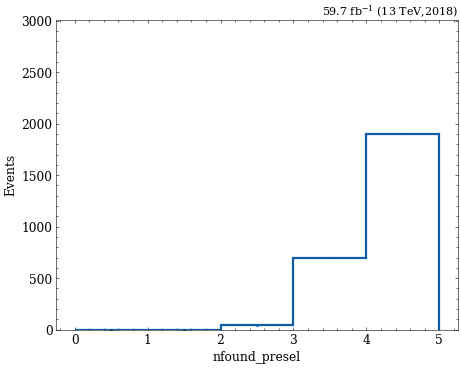

In [6]:
study.quick(
    signal,
    varlist=[nfound_presel]
)

In [7]:
signal.apply(fourb.load_true_assignment)

[None]

In [8]:
signal.apply(lambda t : fourb.load_true_assignment(t, use_regressed=False, tag='unreg_'))

[None]

100%|██████████| 1/1 [00:00<00:00,  3.72it/s]


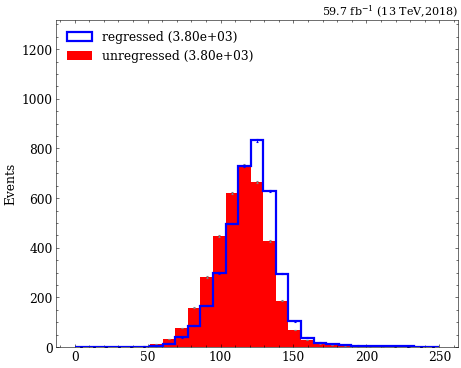

In [14]:
study.overlay(
    signal,
    masks=lambda t : nfound_presel(t)==4,
    h_color=['blue','red'],
    h_label=['regressed','unregressed'],
    varlist=['true_h_m','unreg_h_m'],
    binlist=[(0,250,30)],
    legend=True,
)

In [10]:
true_h_m = signal.apply( lambda t : t.true_h_m[nfound_presel(t) == 4] )[0]
true_h_pt = signal.apply( lambda t : t.true_h_pt[nfound_presel(t) == 4] )[0]

(<Figure size 650x650 with 1 Axes>,
 <AxesSubplot:title={'center':'true_h_m vs true_h_pt'}, xlabel='true_h_m', ylabel='true_h_pt'>)

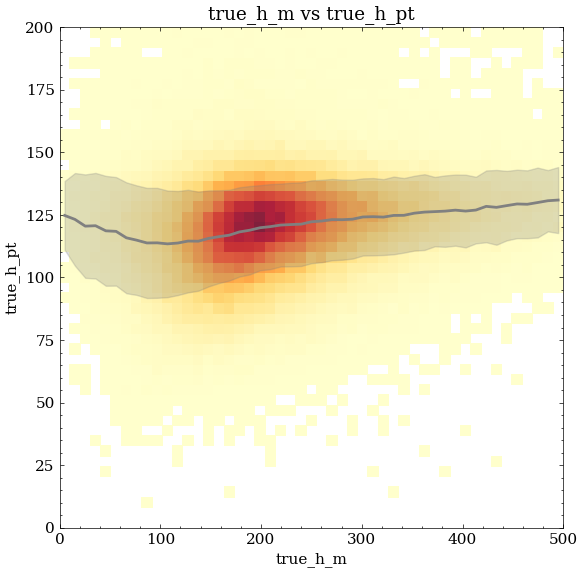

In [11]:
histo2d_array(
    true_h_pt, 
    true_h_m, 
    x_bins=np.linspace(0,500,50), y_bins=np.linspace(0,200,50), 
    xlabel='true_h_m', ylabel='true_h_pt', title='true_h_m vs true_h_pt',
    exe=plot_histo2d_x_corr
)

In [12]:
from utils.plotUtils.function import crystalball

(<Figure size 960x400 with 2 Axes>,
 <AxesSubplot:title={'center':'Valiation of fit to true_h_m'}>)

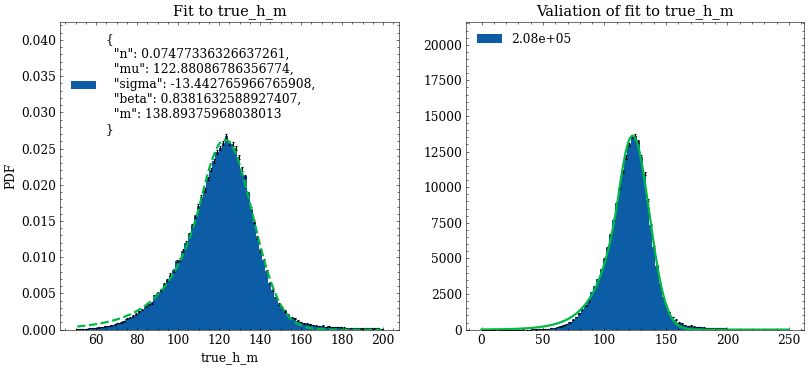

In [13]:
import json

fig, axs = study.get_figax(2)

_, _, h = histo_array(true_h_m, bins=(50,200,100), legend=True,  density=True, h_fit='crystalball_left', h_fit_show=True, h_label_stat=lambda h:json.dumps(h.fit.params, indent=2), figax=(fig, axs[0]))
axs[0].set(title='Fit to true_h_m', xlabel='true_h_m')

fit = h.fit

fig, ax, h = histo_array(true_h_m, bins=(0,250,100), legend=True, figax=(fig, axs[1]))
axs[1].set(title='Valiation of fit to true_h_m', xlabel='true_h_m')

x = np.linspace(0, 250, 1000)
y = fit.func(x)

y /= np.max(y)

norm = np.max(h.histo) / np.max(y)
graph_array(
    x, y * norm,
    figax=(fig ,axs[1])
)

In [248]:
import yaml 

f_eq = f"""
x < {x[0]} : 0
(x >= {x[0]}) & (x <= {x[-1]}) : { np.stack([x,y],axis=1).tolist() }
x > {x[-1]} : 0
"""
f_eq = yaml.safe_load(f_eq)
with open('hh_m_fit.yaml', 'w') as f:
    yaml.dump(f_eq, f, sort_keys=False)


In [250]:
from utils.equation import Piecewise

eq = Piecewise.from_yaml('hh_m_fit.yaml')

(<Figure size 650x650 with 1 Axes>, <AxesSubplot:>)

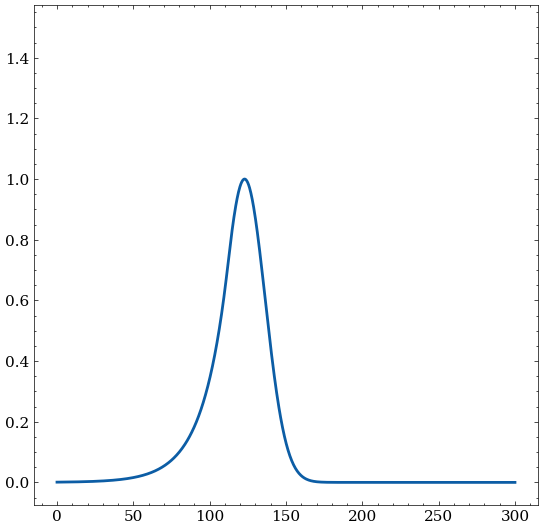

In [251]:
xp = np.linspace(0, 300, 1000)
yp = eq(xp)
graph_array(xp, yp)